# Full Animation: PID Throttle Control and Stanley Steering

In this exercise, you will be developing a complete animation of an autonomous car that utilizes **PID control** for throttle and **Stanley control** for steering. You'll implement the missing pieces of the code and adjust parameters to improve performance.

Basically we are gonna combine everything learnt till now to create a full working animation of how the car will run on the track.

We started by getting cone positions, we then got waypoints and interpolated them. We then optimised them. 

Now that we have the optimised path, we will use our knowledge of PID control and Stanley steering to race the car on the track!

A very simple point mass model has been implemented as the car for initial testing.

## Objectives:
1. Implement **PID throttle control** to maintain a desired speed.
2. Implement **Stanley steering** to follow a predefined path.
3. Tune the Stanley controller to achieve better path tracking.
4. Visualize the system's behavior using an animation.



In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from utilities import stanley_steering, pid_throttle
import time




     



Initially to get started load the map(waypoints) and plot to see the path you are trying to traverse


Add the Cones for Visualisation to make the animation look prettier


You can find all these files in the 'Checkpoint 4' folder

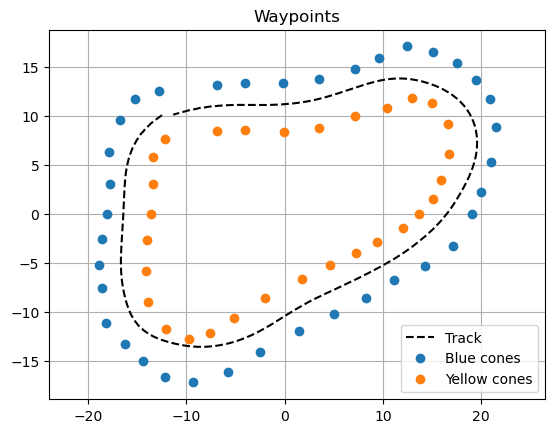

In [38]:
waypoints = np.load('waypoints.npy')
# Ensure that these are numpy arrays for cone positions
blue_cones = np.load('blue_cones.npy')  # Shape should be (N, 2)
yellow_cones = np.load('yellow_cones.npy')  # Shape should be (N, 2)

# Plot the track and cones
plt.plot(waypoints[:, 0], waypoints[:, 1], 'k--', label="Track")
plt.plot(blue_cones[:, 0], blue_cones[:, 1], marker='o', linestyle='None', label="Blue cones")
plt.plot(yellow_cones[:, 0], yellow_cones[:, 1], marker='o', linestyle='None', label="Yellow cones")
plt.axis("equal")
plt.title("Waypoints")
plt.legend()
plt.grid()
plt.show()



#### Implement the car model
Currently the skeleton code has a kinematic bicylce model already implemented for you :)

##### Bonus:

After you implement the whole animation using this model you can try to implement the dynamic bicycle model you learned in AISD module

In [39]:
# Vehicle class definition
class Vehicle:
    def __init__(self, x=-10.5, y=10.5, yaw=0, v=0.0, L=2.5):  # Initial position, yaw, velocity, and wheelbase
        self.x = x  # IMP! : Change the initial pose of the car to determine the starting position
        self.y = y
        self.yaw = yaw
        self.v = v
        self.L = L  # Wheelbase

    def update(self, throttle, delta, dt=0.1):
        self.x += self.v * np.cos(self.yaw) * dt
        self.y += self.v * np.sin(self.yaw) * dt
        self.yaw += self.v / self.L * np.tan(delta) * dt
        self.v += throttle * dt
        self.v = max(0.0, self.v)  # No reverse
     


### Implement Throttle and Steering control
 - Implement a PID controller for throttle to follow the velocity profile you created earlier
 - Implement the stanley controller function you created in the previous notebook for steering control
 - You will have to add these control functions in the utilities and then import them here to use them 

In [64]:
def compute_control(vehicle, waypoints, target_idx, prev_error, integral, dt):
    """
    Compute throttle and steering commands based on the vehicle's state and PID control.
    """
    # PID throttle control
    target_v = 5.0  # Target speed (m/s)
    
    # Pass prev_error and integral explicitly as arguments to avoid confusion
    throttle, prev_error, integral = pid_throttle(target_v, vehicle.v, prev_error, integral, dt)

    # Stanley steering control with proper parameters
    k = 1.0  # Cross-track error gain
    k_soft = 1e-2  # Softening term
    steer, target_idx = stanley_steering(vehicle.x, vehicle.y, vehicle.yaw, vehicle.v, waypoints, k=k, ks=k_soft)

    return throttle, steer, target_idx, prev_error, integral


TypeError: 'Line2D' object is not subscriptable

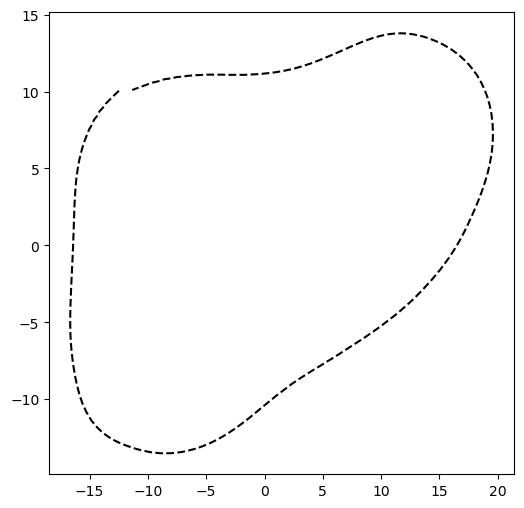

In [65]:
# Initialize the vehicle object and history storage
vehicle = Vehicle()
history = {'x': [], 'y': []}
target_idx = 0

# Initialize PID controller variables
prev_error = 0.0
integral = 0.0

fig, ax = plt.subplots(figsize=(6,6))
# ax.set_xlim(-12, 12)
# ax.set_ylim(-12, 12)
# Fix the cone plotting
track_line, = ax.plot(waypoints[:,0], waypoints[:,1], 'k--')
blue_cones_plot, = ax.plot(blue_cones[:,0], blue_cones[:,1], 'bo', linestyle='None', label="Blue cones")
yellow_cones_plot, = ax.plot(yellow_cones[:,0], yellow_cones[:,1], 'yo', linestyle='None', label="Yellow cones")
car_dot, = ax.plot([], [], 'ro', markersize=6)
path_line, = ax.plot([], [], 'b-', linewidth=1)

def init():
    """Initialize the animation"""
    car_dot.set_data([], [])
    path_line.set_data([], [])
    return car_dot, path_line


# Initialize the previous time (for calculating dt)
prev_time = time.time()
def animate(i):
    global target_idx, prev_error, integral, prev_time

    # Calculate the time step (dt)
    current_time = time.time()
    dt = current_time - prev_time
    prev_time = current_time

    # Compute throttle and steering
    throttle, steer, target_idx, prev_error, integral = compute_control(vehicle, waypoints, target_idx, prev_error, integral, dt)
    
    # Update vehicle's state
    vehicle.update(throttle, steer)
    
    # Record history for visualization
    history['x'].append(vehicle.x)
    history['y'].append(vehicle.y)

    # Update the plot
    car_dot.set_data(vehicle.x, vehicle.y)
    path_line.set_data(history['x'], history['y'])
    
    return car_dot, path_line, track_line, blue_cones_plot, yellow_cones_plot
ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=700, interval=50, blit=True)

plt.close()  # Prevent double display in some notebooks

from IPython.display import HTML
HTML(ani.to_jshtml())


